# PyTorch Custom Datasets
Reference book --> https://www.learnpytorch.io/04_pytorch_custom_datasets/

We've used the datasets which PyTorch provides, but how to use our own data for training and testing? Let's find out

## Domain Libraries
Depending on what kind problem we're working on, text, audio, vision, recommendation, we'll look into PyTorch domain libraries for existing data loading functions and customizable data loading functions.

We're working on a vision problem, so we'll be checking out the custom data loading functions for `torchvision`.

## 0. Importing PyTorch and setting up device agnostic code


In [132]:
import torch
from torch import nn

torch.__version__

'2.2.1+cu121'

In [133]:
# Setup device agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='cpu')

In [134]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## 1. Get Data
Our dataset is the subset of Food101 dataset.

Food101 has 101 different classes of food and 1000 images per class. (750 testing, 250 training).

Our dataset has only 3 classes of images and 10% of the data (75 testing images, 25 training images). We're doing this to speed up our experiments as larger dataset would take too long for computation.

In [135]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder.
data_path = Path('data/')
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download and unzip
if image_path.is_dir():
  print(f'{image_path} already exists... Skipping Download.')
else:
  print(f'{image_path} does not exist. Creating directory...')
  image_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak, sushi data, wb=write binary
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  # Unzip pizza, steak, sushi data, r=read mode.
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi already exists... Skipping Download.


## 2. Becoming one with the data (data preparation and exploration)

`os.walk()` is used to traverse all the branches of the root directory completely from top to bottom. `os.walk()` generates the file names in a directory tree by walking the tree either top-down or bottom-up. For each directory in the tree rooted at directory top (including top itself), it yields a 3-tuple (dirpath, dirnames, filenames).

* `root` : Prints out directories only from what you specified.

* `dirs` : Prints out sub-directories from root.

* `files` : Prints out all files from root and directories.

In [136]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir path returning it's contents.
  """

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [137]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.


We have PyTorch's [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) which we're going to use to load our data. So, our data is to be stored in the format mentioned in the documentation.

In [138]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

What we have to do:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name from `pathlib.Path.parent.stem`
4. Let's open the image from python's image library `PIL`
5. Show the image and print metadata

data/pizza_steak_sushi/test/steak/1302563.jpg
steak
Random image path: data/pizza_steak_sushi/test/steak/1302563.jpg
Image class: steak
Image height: 512
Image width: 512


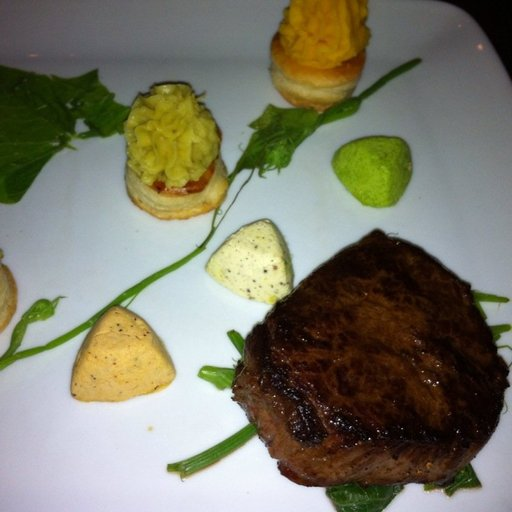

In [139]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name (the img class is name of directory in which it's stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open Image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img

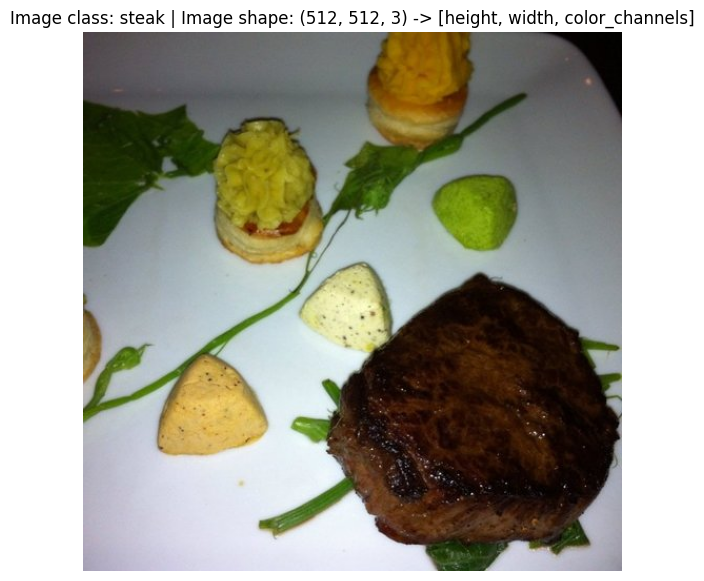

In [140]:
# Try to visualize the image with matplotlib.
import matplotlib.pyplot as plt
import numpy as np

# Turn the image into array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]')
plt.axis(False);

array([[[ 76,  66,  67],
        [ 77,  67,  68],
        [ 77,  68,  71],
        ...,
        [  2,   2,   0],
        [  3,   3,   1],
        [  3,   3,   1]],

       [[ 76,  66,  67],
        [ 77,  67,  68],
        [ 77,  68,  71],
        ...,
        [  2,   2,   0],
        [  3,   3,   1],
        [  3,   3,   1]],

       [[ 75,  65,  66],
        [ 77,  67,  68],
        [ 78,  69,  72],
        ...,
        [  2,   2,   0],
        [  3,   3,   1],
        [  3,   3,   1]],

       ...,

       [[164, 159, 179],
        [164, 159, 179],
        [165, 160, 180],
        ...,
        [144, 142, 155],
        [142, 140, 153],
        [141, 139, 152]],

       [[164, 159, 179],
        [165, 160, 180],
        [165, 160, 180],
        ...,
        [145, 143, 157],
        [144, 142, 156],
        [144, 142, 156]],

       [[166, 161, 181],
        [166, 161, 181],
        [167, 162, 182],
        ...,
        [146, 144, 158],
        [147, 145, 159],
        [148, 146, 160]]], dtype=uint8)
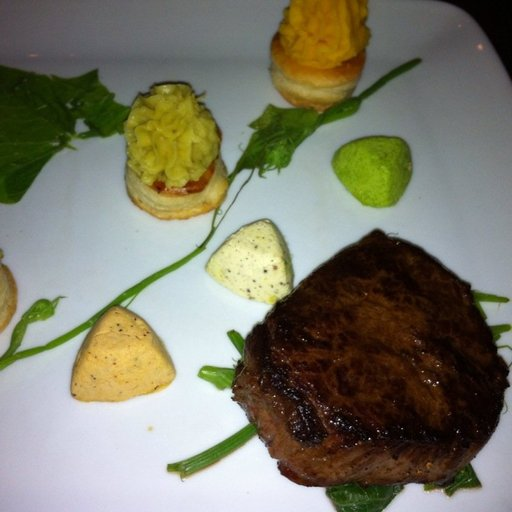

In [141]:
img_as_array  # Numpy array

## 3. Transforming data

Before we can use our image data with PyTorch -
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently into `torch.utils.data.DataLoader`

In [142]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to work with the model. They also help with data augmentation.
[`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) documentation.

In [143]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to same size
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal (augmentation)
    transforms.RandomHorizontalFlip(p=0.5),  # Flips img 50% of times
    transforms.ToTensor()
])

In [144]:
data_transform(img).shape, data_transform(img).dtype

(torch.Size([3, 64, 64]), torch.float32)

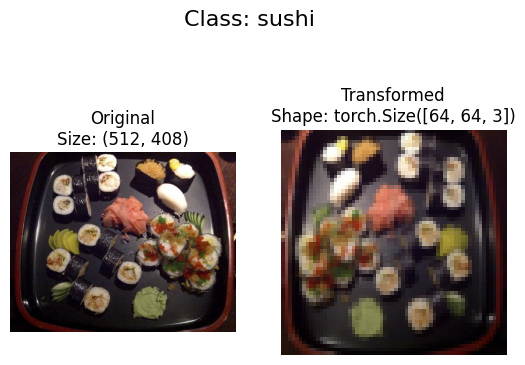

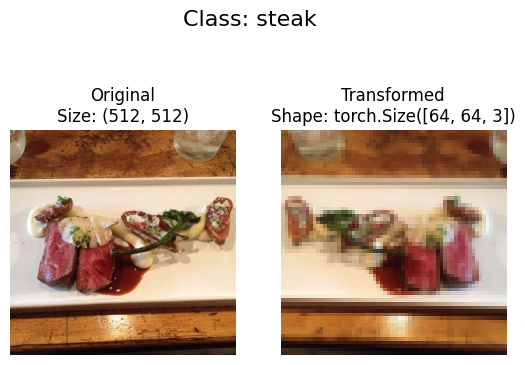

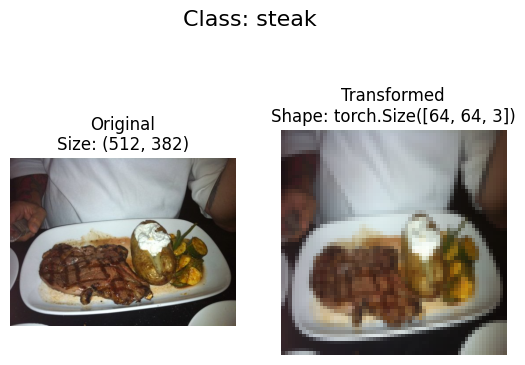

In [145]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs transformed version.
  """

  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original\nSize: {f.size}')
      ax[0].axis(False)

      # Transform and plot target image
      # This throws errror. # matplotlib expects height, width, color channels. This is channels, height, width.
      # transformed_image = transform(f)
      transformed_image = transform(f).permute(1, 2, 0) # Changes to HWC.
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
      ax[1].axis('off')

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths = image_path_list,
                        transform = data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html).

In [146]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform, # A transform for the data
                                  target_transform = None)  # A transform for the target (label)

test_data = datasets.ImageFolder(root = test_dir, transform = data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [147]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [148]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [149]:
# Check lengths of datasets
len(train_data), len(test_data)

(225, 75)

In [150]:
# Looking at the first sample.
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [151]:
# Index on train_data Dataset to get a single image and it's label
train_data[0]

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

In [152]:
img, label = train_data[0][0], train_data[0][1]
print(f'Image tensor: \n{img}')
print(f'Image tensor shape: {img.shape}')
print(f'Image tensor type: {img.dtype}')

Image tensor: 
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

In [153]:
print(f'Label: {label}')
print(f'Label datatype: {type(label)}') # The label is a scalar value. It's not a tensor.
print(f'Label class: {class_names[label]}') # Getting class name from label.

Label: 0
Label datatype: <class 'int'>
Label class: pizza


Image tensor shape: torch.Size([3, 64, 64]) --> [color_channels, height, width]
Permuted image tensor shape: torch.Size([64, 64, 3]) --> [height, width, color_channels]


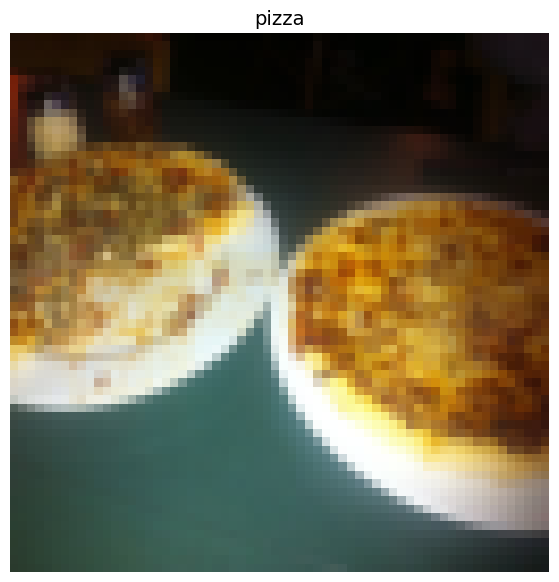

In [154]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f'Image tensor shape: {img.shape} --> [color_channels, height, width]')
print(f'Permuted image tensor shape: {img_permute.shape} --> [height, width, color_channels]')

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize = 14);

### 4.1 Turn loaded datasets into `DataLoader`(s)

A `DataLoader` is going to help us turn out `Dataset`s into iterables and we can customize the `BATCH_SIZE` to make our model see a fixed number of images in a single iteration instead of feeding it all the images at once.

In [155]:
import os
os.cpu_count()

2

In [156]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, num_workers=os.cpu_count(), shuffle=False)

In [157]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c15bdff5ea0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c15bdff5fc0>)

In [158]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [159]:
img, label = next(iter(train_dataloader))

# You can change the batch size to a different number. Here it's 1 as shown in batch dimension.
print(f'Image shape: {img.shape} --> [batch_size, color_channels, height, width]')
print(f'Label shape: {label.shape} --> [batch_size]')

Image shape: torch.Size([1, 3, 64, 64]) --> [batch_size, color_channels, height, width]
Label shape: torch.Size([1]) --> [batch_size]


## 5. Option 2: Loading image data with a custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the dataset.
3. Want to be able to get classes as dictionary from the dataset.

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions.

Cons:
* Eventhough you could create a `Dataset` out of almost anything, it doesn't mean it will work
* Creating custom `Dataset` requires writing more code, which could lead to errors or performance issues.

Almost all custom datasets in PyTorch subclass [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)

In [160]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [161]:
# Instance of torchvision.datasets.ImageFolder()
# We want to recreate this functionality using our own custom Dataset.
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get the class names

We want the function to:
- Get class names using `os.scandir()` to traverse a target directory (ideally, the directory is in standard image classification format)
- Raise an error if class names aren't found (if this happens, there must be something wrong with directory structure)
- Turn class names into a dict and list and return them.

In [162]:
# Checking what scandir does -
list(os.scandir(train_dir))

[<DirEntry 'steak'>, <DirEntry 'pizza'>, <DirEntry 'sushi'>]

[`os.scandir()`](https://www.geeksforgeeks.org/python-os-scandir-method/) ->
Like `listdir`, `scandir` calls the operating system’s directory iteration system calls to get the names of the files in the given `path`, but it’s different from `listdir` in two ways:

1. Instead of returning bare filename strings, it returns lightweight `DirEntry` objects that hold the filename string and provide simple methods that allow access to the additional data the operating system may have returned.
2. It returns a generator instead of a list, so that `scandir` acts as a true iterator instead of returning the full list immediately.

Basically, it returns the names of all the directories and files in the provided path as `DirEntry` objects. We put all the objects into a list and iterate through each entry in the list. `DirEntry` objects have attribute `name` which gives us the name of the directory/file.

In [163]:
# Setup path for target directory
target_directory = train_dir
print(f'Target directory: {target_directory}')

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target directory: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [164]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """
  Input:
  directory: The directory containing the data.
  Output:
  Returns a tuple containing a list of class names and a dictionary with class names mapped to respective indices(targets)
  """
  # 1. Get class names by scanning the target directory
  classes = sorted(entry.name for entry in list(os.scandir(directory)) if entry.is_dir())

  # 2. Raise an error if class names are not found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure")

  # 3. Create a dictionary which maps classes to indices.
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [165]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create custom `Dataset` to replicate `ImageFolder`

To create a custom dataset, we want to:
1. Subclass `torch.utils.data.Dataset`
2. Init our own subclass with a target directory (the directory we'd like to get the data from) as well as a transform if we'd like to transform our data.
3. Create several attributes -
  * paths - paths of our images
  * transforms - transforms we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of target classes mapped to indices
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len__()` method to return the length of our dataset.
6. Overwrite the `__getitem__()` method to return a given sample when passed an index.

In [166]:
# Write custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

  # 2. Initialize our class with target directory and transforms
  def __init__(self,
               targ_dir: str,
               transform = None):
    super().__init__()

    # 3. Create class attributes.
    # Get all the image paths
    self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg')) # Gives all paths that follow the pattern specified in glob.
    # Setup transforms
    self.transform = transform
    # Use helper function to get classes and class_to_idx
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create function to load images
  def load_images(self, index: int) -> Image.Image:
    """ Opens an image via a path and returns it. """
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite the len method to get length of our dataset.
  def __len__(self) -> int:
    """ Returns the total number of images in our dataset. """
    return len(self.paths)

  # 6. Overwrite __getitem__() method. This decides what to return when indexing.
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img = self.load_images(index) # Not converting to tensor. Will do it in transforms.
    target_class = self.paths[index].parent.name  # Returns the name of the parent directory of the image, which is the target/label.
    class_idx = self.class_to_idx[target_class]

    # Transform if necessary
    if self.transform:
      img = self.transform(img)

    return img, class_idx

In [167]:
# Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [168]:
# Testing our custom datasets
train_data_custom = ImageFolderCustom(train_dir, train_transforms)
test_data_custom = ImageFolderCustom(test_dir, test_transforms)

In [169]:
train_data_custom[0]

(tensor([[[0.1882, 0.1686, 0.0902,  ..., 0.2039, 0.2196, 0.2118],
          [0.2039, 0.2000, 0.1294,  ..., 0.2471, 0.1882, 0.1569],
          [0.2039, 0.3137, 0.2902,  ..., 0.3843, 0.4000, 0.3098],
          ...,
          [0.3216, 0.3412, 0.3373,  ..., 0.0392, 0.0510, 0.0627],
          [0.2706, 0.3020, 0.3176,  ..., 0.0510, 0.0549, 0.0706],
          [0.2667, 0.2510, 0.2824,  ..., 0.0588, 0.0627, 0.0745]],
 
         [[0.1843, 0.1490, 0.0863,  ..., 0.1765, 0.2078, 0.1882],
          [0.1961, 0.1843, 0.1137,  ..., 0.2078, 0.1725, 0.1490],
          [0.1804, 0.2627, 0.2196,  ..., 0.2980, 0.3176, 0.2353],
          ...,
          [0.2784, 0.2941, 0.3020,  ..., 0.0353, 0.0471, 0.0588],
          [0.2392, 0.2667, 0.2784,  ..., 0.0471, 0.0510, 0.0667],
          [0.2314, 0.2235, 0.2431,  ..., 0.0549, 0.0588, 0.0706]],
 
         [[0.2000, 0.1529, 0.0980,  ..., 0.1569, 0.1961, 0.1765],
          [0.2118, 0.1765, 0.1137,  ..., 0.1843, 0.1686, 0.1529],
          [0.1843, 0.2078, 0.1647,  ...,

In [170]:
train_data_custom.class_to_idx, train_data_custom.classes

({'pizza': 0, 'steak': 1, 'sushi': 2}, ['pizza', 'steak', 'sushi'])

In [171]:
len(train_data_custom), len(test_data_custom)

(225, 75)

### 5.3 Create a helper function to visualize random images

To create the folder, we want this to do:
1. Take dataset, classe names, number of images to display as inputs.
2. Let's cap the max number of images which we can display to 10.
3. Set random seed for reproducability.
4. Get a list of random sample indices from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample images and plot them with matplotlib making sure the dimensions of our images are compatible with matplotlib (HWC)

In [172]:
import random
import matplotlib.pyplot as plt
def visualize_random_images(dataset: torch.utils.data.Dataset,
                            classes: List[str] = None,
                            n: int = 10,
                            display_shape: bool = True,
                            seed: int = None):

  # 2. Adujust display if n is too high
  if n>10:
    n=10
    display_shape=False
    print(f"For display purposes, n shouldn't be larget than 10, setting n to 10 and removing shape display")

  # 3. Set seed
  if seed:
    random.seed(seed)

  # 4. Get a list of random sample indices from target dataset
  # rand_idx = []
  # for i in range(n):
  #   rand_idx.append(random.randint(0, len(dataset)))
  random_samples_idx = random.sample(range(len(dataset)), k=n) # Get n samples from range 0 to length of dataset.

  # 5. Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through images and plot them
  for i, targ_sample in enumerate(random_samples_idx):
    targ_img, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Change dimensions of image for matplotlib
    targ_img_adjust = targ_img.permute(1, 2, 0)

    plt.subplot(1, n, i+1)
    plt.imshow(targ_img_adjust)
    plt.axis(False)
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title += f"\nShape: {targ_img_adjust.shape}"
    plt.title(title);

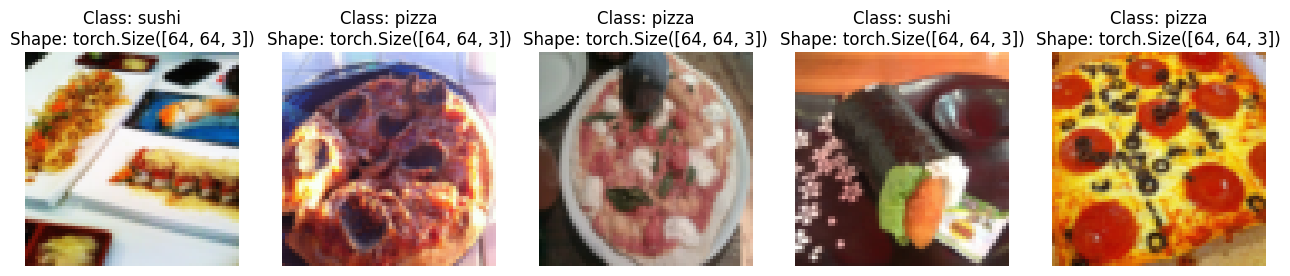

In [173]:
# Using the helper function to display the images from ImageFolder dataset.
visualize_random_images(train_data, n=5, classes = class_names, seed=42)

For display purposes, n shouldn't be larget than 10, setting n to 10 and removing shape display


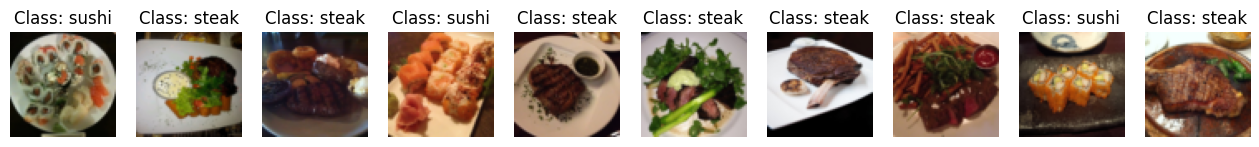

In [174]:
# Use the helper function to display the images from the Custom Dataset that we created.
visualize_random_images(train_data_custom, n=20, classes = train_data_custom.classes, seed=42)

### 5.4 Turning our custom dataset into `DataLoader`

We can use the `DataLoader` on our custom `Dataset` since it subclasses the Dataset module. We made sure they're compatible by overriding the `__getitem__()` and `__len__()` functions.

In [175]:
from torch.utils.data import DataLoader

train_dataloader_custom = DataLoader(train_data_custom, batch_size=1, shuffle=True, num_workers=os.cpu_count())
test_dataloader_custom = DataLoader(test_data_custom, batch_size=1, shuffle=False, num_workers=os.cpu_count())

# next(iter(train_dataloader_custom))

In [176]:
# Get items from the dataloader and check their shapes for more info.
img_custom, label_custom = next(iter(train_dataloader_custom))

# Expected output :
# img shape --> [batch_size, channels, height, width]
# label shape --> [batch_size]
img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## 6. Checking out more forms of data augmentation in PyTorch

Data augmentation is the process of altering your data in such a way that you artificially increase the diversity of your training set.

![image.png](https://raw.github.com/suryansh-sinha/Learning-PyTorch/main/Daniel%20Bourke/images/04_PyTorch_Custom_Datasets/DataAugmentation.webp)

Training a model on this artificially altered dataset hopefully results in a model that is capable of better generalization (the patterns it learns are more robust to future unseen examples).

Let's see how we can use pre-existing PyTorch transforms given in [`torchvision.transforms.v2`](https://pytorch.org/vision/stable/transforms.html) to do data augmentation for our images.

Since the release of torch 2.0, they've released `torchvision.transforms.v2` which has newer and faster transform methods available. This section is updated with the use of version 2.0

We're going to use Trivial Augment by PyTorch, which was used as the augmentation technique to train their state of the art models.
TrivialAugment randomly selects an augmentation and then applies it with a selected strength.

We can see it's performance in the image below -
![trivialaugment.png](https://raw.github.com/suryansh-sinha/Learning-PyTorch/main/Daniel%20Bourke/images/04_PyTorch_Custom_Datasets/trivial-augment-performance.png)

More on Trivial Augment --> https://medium.com/geekculture/trivialaugment-the-next-evolution-in-data-augmentation-a218339a2687

In [177]:
from torchvision.transforms import v2 as transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.PILToTensor()
])

# Don't need augmentation for our test data.
test_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.PILToTensor()
])

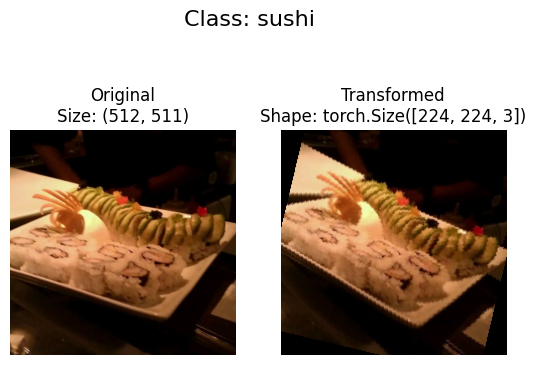

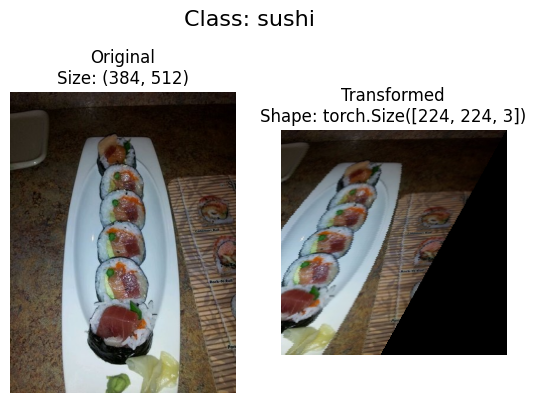

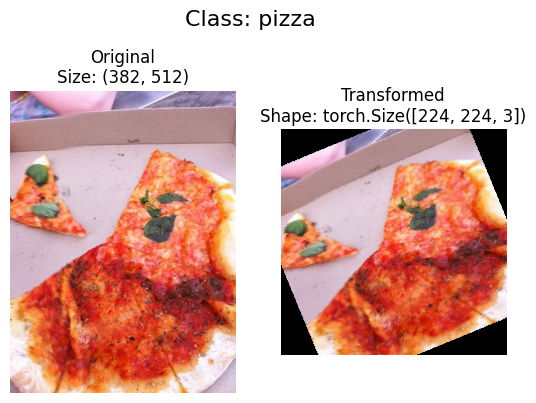

In [178]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

## 7. Model0: TinyVGG without Data Augmentation

We'll create a baseline model replicating the TinyVGG architecture and we will not use data augmentation here, so that when we use it later, we can compare the performances.

### 7.1 Creating transforms and loading data for Model0

What we're doing:
* Creating a simple transform which has resize and converts to tensor.
* Create a dataloader from our dataset using the transform that we create.

In [225]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.PILToTensor(),
    transforms.ToDtype(torch.float32, scale=True)
])

In [226]:
# Create a new dataloader that uses the transform specified above.
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7c15bdf12890>,
 <torch.utils.data.dataloader.DataLoader at 0x7c15bdf13910>)

### 7.2 Creating the Model0

The model replicates the TinyVGG architecture from the cnn-explainer website we showed in previous notebooks.

In [227]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    CONV_SIZE = 3
    CONV_STRIDE = 1


    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(input_shape, hidden_units, CONV_SIZE, CONV_STRIDE, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, CONV_SIZE, CONV_STRIDE, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, CONV_SIZE, CONV_STRIDE, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, CONV_SIZE, CONV_STRIDE, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden_units * 16* 16, output_shape),
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

model0 = TinyVGG(3, 10, 10).to(device)
model0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=10, bias=True)
  )
)

### 7.3 Testing the model on a single image.

Checking the if our model is working correctly by checking if all the dimensions are correct. Also checking what our outputs look like with their shapes and all.

In [228]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model0.eval()
with torch.inference_mode():
  pred = model0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[ 0.0139, -0.0092,  0.0097,  0.0612,  0.0147, -0.0193, -0.0229,  0.0612,
          0.0009, -0.0228]])

Output prediction probabilities:
tensor([[0.1005, 0.0982, 0.1001, 0.1053, 0.1006, 0.0972, 0.0968, 0.1053, 0.0992,
         0.0969]])

Output prediction label:
tensor([7])

Actual label:
2


### 7.4 Using `torchinfo` to get an idea of the shapes in our model

Printing out our model with print(model) gives us an idea of what's going on with our model.

And we can print out the shapes of our data throughout the forward() method.

However, a helpful way to get information from our model is to use torchinfo.

`torchinfo` comes with a `summary()` method that takes a PyTorch model as well as an `input_shape` and returns what happens as a tensor moves through your model.

In [229]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### 7.5 Create train and test loop functions

In [230]:
### Training function
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               optimizer: torch.optim,
               loss_fn):

  # Training mode
  model.train()

  # Setup train loss and accuracy
  train_loss, train_acc = 0, 0

  # Loop through each batch of data
  for batch, (image, label) in enumerate(dataloader):

    # Moving data to appropriate devices.
    image = image.to(device)
    label = label.to(device)

    # 1. Forward pass
    logits = model(image)

    # 2. Calculate the loss
    loss = loss_fn(logits, label)
    train_loss += loss.item()

    # 3. Set gradients to zero
    optimizer.zero_grad()

    # 4. Backprop on loss
    loss.backward()

    # 5. Update the parameters.
    optimizer.step()

    # Calculate the accuracy metric.
    y_pred_class = torch.argmax(torch.softmax(logits, dim=1), dim=1)
    train_acc += torch.eq(y_pred_class, label).sum().item()/len(logits)

  # Dividing the loss and accuracy per batch.
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

In [231]:
### Testing Function
def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn):

  # Testing mode
  model.eval()
  with torch.inference_mode():

    test_loss, test_acc = 0, 0

    for batch, (image, label) in enumerate(dataloader):

      # Moving data to appropriate devices.
      image = image.to(device)
      label = label.to(device)

      # Predictions from our model
      logits = model(image)

      # Calculating the loss
      loss = loss_fn(logits, label)
      test_loss += loss.item()

      # Calculating the accuracy
      y_pred_label = torch.argmax(torch.softmax(logits, dim=1), dim=1)
      test_acc += torch.eq(y_pred_label, label).sum().item()/len(logits)

    # Calculating average loss and average acc
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

### 7.6 Create a `train()` function that combines `train_step()` and `test_step()`:

Combining the helper functions we created above to actually train the model.

In [232]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer = optimizer)

        test_loss, test_acc = test_step(model = model,
                                        dataloader = test_dataloader,
                                        loss_fn = loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### 7.7 Train and Evaluate Model0

Time to put our TinyVGG model, DataLoaders and train() function together to see if we can build a model capable of discerning between pizza, steak and sushi!

Let's recreate `model0` (we don't need to but we will for completeness) then call our `train()` function passing in the necessary parameters.

To keep our experiments quick, we'll train our model for 5 epochs (though you could increase this if you want).

As for an optimizer and loss function, we'll use `torch.nn.CrossEntropyLoss()` (since we're working with multi-class classification data) and `torch.optim.Adam()` with a learning rate of `1e-3` respecitvely.

To see how long things take, we'll import Python's `timeit.default_timer()` method to calculate the training time.

In [233]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG (optional)
model0 = TinyVGG(3, 10, 10).to(device)

# Setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model0.parameters(), lr=1e-3)

# Start the timer
from timeit import default_timer as timer
timer_start = timer()

model0_results = train(model0, train_dataloader_simple, test_dataloader_simple, optimizer, loss_fn, NUM_EPOCHS)

# Stop the timer
timer_end = timer()

# Checking and printing the total time taken
print(f"Total Time Taken: {timer_end - timer_start:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7488 | train_acc: 0.2461 | test_loss: 1.2456 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.1454 | train_acc: 0.4180 | test_loss: 1.1026 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.1274 | train_acc: 0.4297 | test_loss: 1.0163 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.1973 | train_acc: 0.2812 | test_loss: 1.0724 | test_acc: 0.5634
Epoch: 5 | train_loss: 1.0751 | train_acc: 0.4180 | test_loss: 1.3255 | test_acc: 0.2604
Total Time Taken: 12.777 seconds


We can see our model performs very badly. This is acceptable since this is just the baseline model. We'll keep improving this as we go ahead.

### 7.8 Let's plot the loss curves of our model.

From the printouts of our `model0` training, it didn't look like it did too well.

But we can further evaluate it by plotting the model's loss curves.

Loss curves show the model's results over time.

And they're a great way to see how your model performs on different datasets (e.g. training and test).

Let's create a function to plot the values in our model0_results dictionary. Then, we'll write a function to extract and plot values from each of the keys.

In [234]:
model0_results

{'train_loss': [1.7488384395837784,
  1.1454109102487564,
  1.127371534705162,
  1.1973468959331512,
  1.0750886723399162],
 'train_acc': [0.24609375, 0.41796875, 0.4296875, 0.28125, 0.41796875],
 'test_loss': [1.2456016937891643,
  1.1026271382967632,
  1.0163434346516926,
  1.072370449701945,
  1.3254995346069336],
 'test_acc': [0.19791666666666666,
  0.2604166666666667,
  0.5416666666666666,
  0.5634469696969697,
  0.2604166666666667]}

In [235]:
model0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [241]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """
  Takes the values train_loss, test_loss and train_acc, test_acc from the results dict and plots them.
  """

  # Get the loss values
  loss = results['train_loss']
  test_loss = results['test_loss']

  # Get the acc values
  acc = results['train_acc']
  test_acc = results['test_acc']

  # Figure out how many epochs were there:
  epochs = len(loss)

  # Printing shapes
  print(f'Loss Shape: {len(loss)}')
  print(f'Test Loss Shape: {len(test_loss)}')
  print(f'Acc Shape: {len(acc)}')
  print(f'Train Acc Shape: {len(test_acc)}')

  # Setup a figure
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='Train Loss')
  plt.plot(epochs, test_loss, label='Test Loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend();

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, label='Train Accuracy')
  plt.plot(epochs, test_acc, label='Test Accuracy')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend();

Loss Shape: 5
Test Loss Shape: 5
Acc Shape: 5
Train Acc Shape: 5


ValueError: x and y must have same first dimension, but have shapes (1,) and (5,)

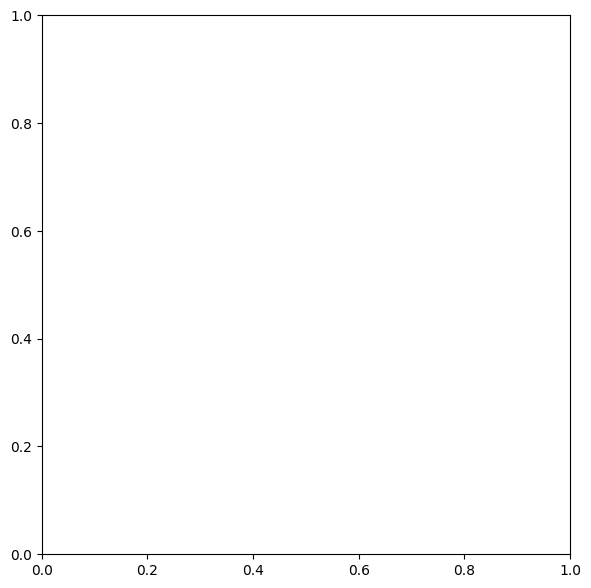

In [243]:
plot_loss_curves(model0_results)